# Yuhua Sandbox

## Algorithm to Automate Novelty Scoring

### Import Packages

In [2]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from functools import reduce
import openpyxl
import xlsxwriter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import ngrams, FreqDist
from nltk.lm import NgramCounter
import string
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
import itertools

from sklearn.metrics.pairwise import cosine_similarity

from scipy import spatial

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

from scipy import stats
from scipy.stats import pearsonr
import pingouin as pg



In [3]:
import os

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/yyu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/yyu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/yyu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Put Data from Excel Sheet into Dataframes

In [4]:
# individual df's for each sheet

# when on pc
data_cup = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_cup_semdis.csv")
data_key = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_key_semdis.csv")
data_rope = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_rope_semdis.csv")
data_brick = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_brick_semdis.csv")
data_chair = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_chair_semdis.csv")
data_pencil = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_pencil_semdis.csv")
data_shoe = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_shoe_semdis.csv")

# when on mac
# data_cup = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_cup_semdis.csv.xlsx")
# data_key = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_key_semdis.csv.xlsx")
# data_rope = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_rope_semdis.csv.xlsx")
# data_brick = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_brick_semdis.csv.xlsx")
# data_chair = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_chair_semdis.csv.xlsx")
# data_pencil = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_pencil_semdis.csv.xlsx")
# data_shoe = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_shoe_semdis.csv.xlsx")

In [7]:
cwd = os.getcwd()
data_cup = pd.read_csv(cwd+'/../data/autdata_test_cup_semdis.csv')

data_key = pd.read_csv(cwd+'/../data/autdata_test_key_semdis.csv')
data_rope = pd.read_csv(cwd+'/../data/autdata_test_rope_semdis.csv')
data_brick = pd.read_csv(cwd+'/../data/autdata_test_brick_semdis.csv')
data_chair = pd.read_csv(cwd+'/../data/autdata_test_chair_semdis.csv')
data_pencil = pd.read_csv(cwd+'/../data/autdata_test_pencil_semdis.csv')
data_shoe = pd.read_csv(cwd+'/../data/autdata_test_shoe_semdis.csv')

### Diversity Calc

In [ ]:

#compute centroid of the list of vectors, as the average of the normalized vectors
def calc_centroid(vector_list):
    vector_len=300 #the length of the embedded vector
    centroid=np.zeros(vector_len)
    for v in vector_list:
        centroid=centroid+v/np.linalg.norm(v)
    centroid=centroid/len(vector_list)
    return centroid

#main function to compute the diversity metric, input is the responses from same participant for a single prompt
#each response is already converted to embedded vectors using certain composition
def calc_diversity(vector_list):
    centroid=calc_centroid(vector_list)
    dist=[]
    for v in vector_list:
        dist.append(1-get_cosine_similarity(centroid,v))
    #return the max of all distance, root mean square of the distance
    #they are equivalent in some sense, root mean squre might behave sligthly better as the diversity metric
    return np.max(dist),np.sqrt(np.mean(np.array(dist)**2))

# novelty

In [39]:
bad_subject=['1363','1622']

In [40]:
folder='/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/'
file='manual_result_all.xlsx'

In [41]:
df=pd.read_excel(folder+file,)
df.head()

xls = pd.ExcelFile(folder+file)
df =pd.DataFrame()
for i in range(8):
    df=pd.concat([df,xls.parse(i)])

In [5]:
df.head()

,id,stim,response,novelty_1,novelty_2
0,1094,Key,to open a door,1.0,1.0
1,1094,Key,to scratch something into the sidewalk,3.0,3.0
2,1094,Key,use to seperate two things that are stuck toge...,4.0,3.0
3,1094,Key,scratch an itch,3.0,3.0
4,1093,Key,unlocking,1.0,1.0


In [38]:
df.describe()

,id,novelty_1,novelty_2
count,3508.000000,3431.000000,3466.000000
mean,1364.772520,2.451180,2.383728
std,165.056958,1.065162,1.090910
min,1087.000000,1.000000,1.000000
25%,1194.000000,2.000000,1.000000
50%,1402.000000,3.000000,2.000000
75%,1511.000000,3.000000,3.000000
max,1622.000000,5.000000,5.000000


In [6]:
tmp=df.groupby('stim').corr().loc[pd.IndexSlice[:, 'novelty_2'],'novelty_1']
tmp.droplevel(None)

stim
Box       0.724004
Brick     0.738499
Chair     0.768833
Cup       0.802415
Key       0.801525
Pencil    0.811083
Rope      0.621854
Shoe      0.825783
Name: novelty_1, dtype: float64

In [43]:
score_by_sub_nov=df[~df['id'].isin(bad_subject)].groupby(['id','stim']).mean()[['novelty_1','novelty_2']]
score_by_sub_nov['novelty_m']=score_by_sub_nov.mean(axis=1)
score_by_sub_nov.head()

novelty_1  novelty_2  novelty_m
id   stim                                  
1087 Box     3.000000   3.500000   3.250000
     Brick   2.833333   3.000000   2.916667
     Chair   2.500000   2.666667   2.583333
     Cup     2.666667   2.333333   2.500000
     Key     2.500000   2.250000   2.375000

In [44]:
metrics=['novelty_1','novelty_2','novelty_m']
icc_df=pd.DataFrame()
for col in metrics:
    icc = pg.intraclass_corr(data=score_by_sub_nov.reset_index(), targets='id', raters='stim', ratings=col,nan_policy='omit')
    icc_df=pd.concat([icc_df,pd.DataFrame(icc.set_index('Type').loc['ICC3k']).T])
icc_df['metrics']=metrics
icc_df=icc_df.drop(labels=['Description'],axis=1).set_index('metrics')
icc_df

,ICC,F,df1,df2,pval,CI95%
metrics,,,,,,
novelty_1,0.742903,3.88958,86,602,5.98504e-23,"[0.65, 0.82]"
novelty_2,0.683935,3.1639,86,602,2.07622e-16,"[0.57, 0.78]"
novelty_m,0.745956,3.93632,86,602,2.26609e-23,"[0.66, 0.82]"


## Semdis

In [32]:
folder='/Users/yyu/PycharmProjects/AUT-Scoring/data/official/semdis/'
sd_df=pd.DataFrame()
for prompt in ['box','brick','chair','cup','key','pencil','rope','shoe']:
    sd_df=pd.concat([sd_df,pd.read_csv(folder+'autdata_official_'+prompt+'_semdis.csv')])

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [22]:
sd_df.describe()

,SemDis_MEAN,SemDis_TASA_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowukwacsubtitle_nf_m,SemDis_factor,SemDis_glove_nf_m,creativity,id,rating,ratings
count,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2.519000e+03,2519.000000,2519.000000,2519.000000,2077.000000,442.000000
mean,0.930812,0.946808,0.937581,0.926492,0.883070,1.190949e-08,0.960109,2.425169,1364.435887,2.334136,2.463801
std,0.126221,0.137981,0.104281,0.125947,0.151825,1.331433e-01,0.212040,1.066428,165.888162,1.074783,1.047533
min,0.513260,0.379120,0.488500,0.491290,0.444560,-4.470300e-01,0.391840,1.000000,1087.000000,1.000000,1.000000
25%,0.884690,0.913320,0.893500,0.872975,0.794610,-5.841000e-02,0.791120,1.000000,1194.000000,1.000000,2.000000
50%,0.968630,0.980770,0.962530,0.957890,0.922320,3.721000e-02,0.970980,3.000000,1402.000000,2.000000,2.500000
75%,1.023520,1.023790,1.005500,1.010425,0.993070,9.277000e-02,1.133380,3.000000,1511.000000,3.000000,3.000000
max,1.117340,1.252030,1.162180,1.198060,1.184890,2.503900e-01,1.400530,5.000000,1622.000000,5.000000,5.000000


In [33]:
metrics=['SemDis_MEAN','SemDis_TASA_nf_m','SemDis_cbowBNCwikiukwac_nf_m','SemDis_cbowsubtitle_nf_m',
              'SemDis_cbowukwacsubtitle_nf_m','SemDis_glove_nf_m']
sd_df.corr()[metrics]

,SemDis_MEAN,SemDis_TASA_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowukwacsubtitle_nf_m,SemDis_glove_nf_m
SemDis_MEAN,1.000000,0.789004,0.873124,0.880402,0.917869,0.864520
SemDis_TASA_nf_m,0.789004,1.000000,0.649182,0.655856,0.647765,0.536216
SemDis_cbowBNCwikiukwac_nf_m,0.873124,0.649182,1.000000,0.761101,0.771303,0.679361
SemDis_cbowsubtitle_nf_m,0.880402,0.655856,0.761101,1.000000,0.802088,0.650434
SemDis_cbowukwacsubtitle_nf_m,0.917869,0.647765,0.771303,0.802088,1.000000,0.740916
SemDis_factor,0.946267,0.709942,0.835836,0.865185,0.925010,0.772016
SemDis_glove_nf_m,0.864520,0.536216,0.679361,0.650434,0.740916,1.000000
creativity,0.275968,0.334107,0.250039,0.262748,0.259991,0.137430
id,0.032890,0.027820,0.038296,0.038370,0.030137,0.015853
rating,0.239513,0.294054,0.248364,0.218237,0.213788,0.117928


In [37]:
score_by_sub_sd=sd_df[~sd_df['id'].isin(bad_subject)].groupby(['id','item']).mean()[metrics]
score_by_sub_sd.head()

SemDis_MEAN  SemDis_TASA_nf_m  SemDis_cbowBNCwikiukwac_nf_m  \
id   item                                                                 
1087 Box       0.946055          0.971292                      0.968102   
     Brick     0.907223          0.903537                      0.886517   
     Chair     0.937640          0.908032                      0.974252   
     Cup       1.005438          0.989217                      0.992120   
     Key       1.038752          0.988947                      0.993845   

            SemDis_cbowsubtitle_nf_m  SemDis_cbowukwacsubtitle_nf_m  \
id   item                                                             
1087 Box                    0.929810                       0.941418   
     Brick                  0.914150                       0.914083   
     Chair                  0.935022                       0.904765   
     Cup                    0.981017                       0.954252   
     Key                    1.058990                       0.968030   

            SemDis_glove_nf_m  
id   item                      
1087 Box             0.919648  
     Brick           0.917833  
     Chair           0.966137  
     Cup             1.110583  
     Key             1.183942

In [38]:
icc_df=pd.DataFrame()
for col in metrics:
    icc = pg.intraclass_corr(data=score_by_sub_sd.reset_index(), targets='id', raters='item', ratings=col,nan_policy='omit')
    icc_df=pd.concat([icc_df,pd.DataFrame(icc.set_index('Type').loc['ICC3k']).T])
icc_df['metrics']=metrics
icc_df=icc_df.drop(labels=['Description'],axis=1).set_index('metrics')
icc_df

,ICC,F,df1,df2,pval,CI95%
metrics,,,,,,
SemDis_MEAN,0.748543,3.97682,86,602,9.77235e-24,"[0.66, 0.82]"
SemDis_TASA_nf_m,0.510906,2.0446,86,602,7.04985e-07,"[0.34, 0.65]"
SemDis_cbowBNCwikiukwac_nf_m,0.735807,3.78511,86,602,5.25273e-22,"[0.64, 0.81]"
SemDis_cbowsubtitle_nf_m,0.695656,3.28575,86,602,1.67671e-17,"[0.59, 0.78]"
SemDis_cbowukwacsubtitle_nf_m,0.765259,4.26002,86,602,2.76177e-26,"[0.68, 0.83]"
SemDis_glove_nf_m,0.638722,2.76795,86,602,6.68583e-13,"[0.51, 0.74]"


# All together

In [57]:
score_by_sub_nov.head()

novelty_1  novelty_2  novelty_m
id   stim                                  
1087 Box     3.000000   3.500000   3.250000
     Brick   2.833333   3.000000   2.916667
     Chair   2.500000   2.666667   2.583333
     Cup     2.666667   2.333333   2.500000
     Key     2.500000   2.250000   2.375000

In [48]:
score_by_sub_sd.index.set_names(['id','stim'],inplace=True)
score_by_sub_sd.head()

SemDis_MEAN  SemDis_TASA_nf_m  SemDis_cbowBNCwikiukwac_nf_m  \
id   stim                                                                 
1087 Box       0.946055          0.971292                      0.968102   
     Brick     0.907223          0.903537                      0.886517   
     Chair     0.937640          0.908032                      0.974252   
     Cup       1.005438          0.989217                      0.992120   
     Key       1.038752          0.988947                      0.993845   

            SemDis_cbowsubtitle_nf_m  SemDis_cbowukwacsubtitle_nf_m  \
id   stim                                                             
1087 Box                    0.929810                       0.941418   
     Brick                  0.914150                       0.914083   
     Chair                  0.935022                       0.904765   
     Cup                    0.981017                       0.954252   
     Key                    1.058990                       0.968030   

            SemDis_glove_nf_m  
id   stim                      
1087 Box             0.919648  
     Brick           0.917833  
     Chair           0.966137  
     Cup             1.110583  
     Key             1.183942

In [49]:
allscores=score_by_sub_nov.merge(score_by_sub_sd,how='inner',left_index=True,right_index=True)
allscores.head()

novelty_1  novelty_2  novelty_m  SemDis_MEAN  SemDis_TASA_nf_m  \
id   stim                                                                    
1087 Box     3.000000   3.500000   3.250000     0.946055          0.971292   
     Brick   2.833333   3.000000   2.916667     0.907223          0.903537   
     Chair   2.500000   2.666667   2.583333     0.937640          0.908032   
     Cup     2.666667   2.333333   2.500000     1.005438          0.989217   
     Key     2.500000   2.250000   2.375000     1.038752          0.988947   

            SemDis_cbowBNCwikiukwac_nf_m  SemDis_cbowsubtitle_nf_m  \
id   stim                                                            
1087 Box                        0.968102                  0.929810   
     Brick                      0.886517                  0.914150   
     Chair                      0.974252                  0.935022   
     Cup                        0.992120                  0.981017   
     Key                        0.993845                  1.058990   

            SemDis_cbowukwacsubtitle_nf_m  SemDis_glove_nf_m  
id   stim                                                     
1087 Box                         0.941418           0.919648  
     Brick                       0.914083           0.917833  
     Chair                       0.904765           0.966137  
     Cup                         0.954252           1.110583  
     Key                         0.968030           1.183942

In [52]:
allscores.corr()

,novelty_1,novelty_2,novelty_m,SemDis_MEAN,SemDis_TASA_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowukwacsubtitle_nf_m,SemDis_glove_nf_m
novelty_1,1.000000,0.718052,0.926670,0.169454,0.203368,0.158291,0.167146,0.172851,0.086901
novelty_2,0.718052,1.000000,0.927003,0.179230,0.212857,0.211111,0.179115,0.173840,0.074848
novelty_m,0.926670,0.927003,1.000000,0.188110,0.224546,0.199312,0.186804,0.187030,0.087251
SemDis_MEAN,0.169454,0.179230,0.188110,1.000000,0.821354,0.895806,0.901282,0.924200,0.887436
SemDis_TASA_nf_m,0.203368,0.212857,0.224546,0.821354,1.000000,0.691105,0.704634,0.695506,0.629106
SemDis_cbowBNCwikiukwac_nf_m,0.158291,0.211111,0.199312,0.895806,0.691105,1.000000,0.804288,0.796461,0.739782
SemDis_cbowsubtitle_nf_m,0.167146,0.179115,0.186804,0.901282,0.704634,0.804288,1.000000,0.855659,0.690253
SemDis_cbowukwacsubtitle_nf_m,0.172851,0.173840,0.187030,0.924200,0.695506,0.796461,0.855659,1.000000,0.748866
SemDis_glove_nf_m,0.086901,0.074848,0.087251,0.887436,0.629106,0.739782,0.690253,0.748866,1.000000


In [56]:
np.round(allscores.groupby(level=0).mean().corr(),3)

,novelty_1,novelty_2,novelty_m,SemDis_MEAN,SemDis_TASA_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowukwacsubtitle_nf_m,SemDis_glove_nf_m
novelty_1,1.000,0.864,0.967,0.304,0.471,0.302,0.269,0.307,0.179
novelty_2,0.864,1.000,0.964,0.289,0.435,0.287,0.264,0.284,0.178
novelty_m,0.967,0.964,1.000,0.307,0.470,0.305,0.276,0.306,0.185
SemDis_MEAN,0.304,0.289,0.307,1.000,0.898,0.956,0.963,0.969,0.939
SemDis_TASA_nf_m,0.471,0.435,0.470,0.898,1.000,0.857,0.844,0.852,0.774
SemDis_cbowBNCwikiukwac_nf_m,0.302,0.287,0.305,0.956,0.857,1.000,0.935,0.904,0.855
SemDis_cbowsubtitle_nf_m,0.269,0.264,0.276,0.963,0.844,0.935,1.000,0.928,0.861
SemDis_cbowukwacsubtitle_nf_m,0.307,0.284,0.306,0.969,0.852,0.904,0.928,1.000,0.878
SemDis_glove_nf_m,0.179,0.178,0.185,0.939,0.774,0.855,0.861,0.878,1.000


# Originality

In [8]:
folder='/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/'
file='originality/results.xlsx'

xls = pd.ExcelFile(folder+file)
df =pd.DataFrame()
for i in range(8):
    df=pd.concat([df,xls.parse(i,header=1,usecols="A:Q")])

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


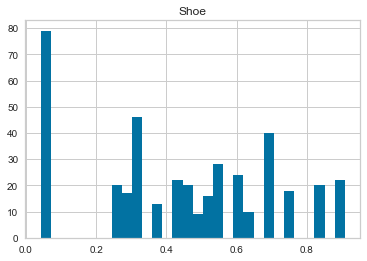

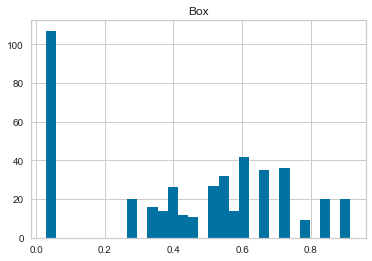

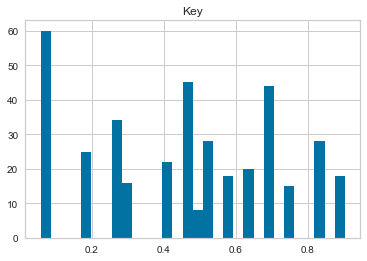

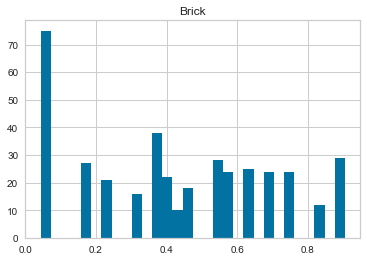

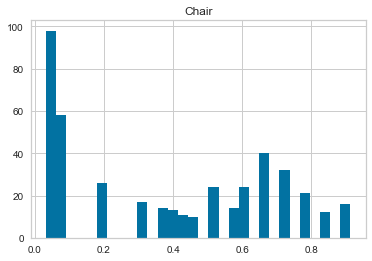

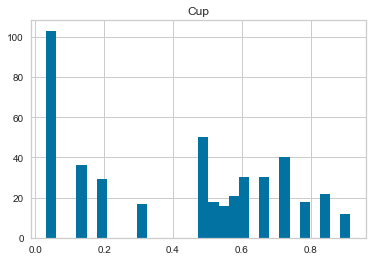

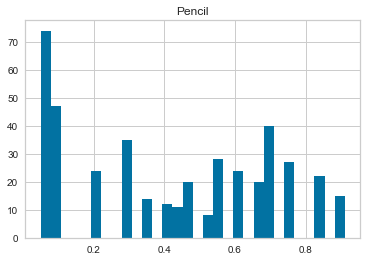

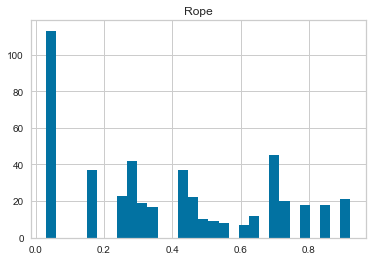

In [59]:
for prompt in ['Shoe','Box','Key','Brick','Chair','Cup','Pencil','Rope']:
    tmp=df[df['item']==prompt]
    tmp['freq']=(1-tmp['cluster_freq'])
    tmp['t_freq']=(.05/(.05+tmp['freq']))**2
    tmp['t_freq'].hist(bins=30)
    plt.title(prompt)
    plt.show()
    plt.close()